# Detect Enron Poi

In [1]:
import sys
import pickle
import pprint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append("./tools/")
sys.path.append("./learning/")
from preprocess import *
import ClassifyNB, ClassifySVM, RFClassifier, PCA
from feature_format import targetFeatureSplit
from tester import test_classifier
from sklearn.pipeline import Pipeline, FeatureUnion

In [2]:
### Load the numpy array with the dataset
data = np.load('data/enrondata_normalized.npy')
features_list = np.load('data/features_list.npy').tolist()

##Question 1: 

Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”] 

The goal of the project is to create a learning model in which to identify persons of interest from the Enron employees. A person of interest in this context indicates a person who could have been of interest in the Enron financial fraud case.

The data used in this task consisted of financial information and information derived from the email messages of a sample of Enron employees. In the dataset, each row consisted of an employee of Enron. The employees had the following fields: 

In [3]:
print features_list

['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'from_poi_to_this_person']


The dataset is very tiny, with only 145 rows 18 of which are POIs. The lack of data and heavy bias towards the output variables being non-POIs will surely affect the resulting model.

This data was analysed to discover the data and to see if there are any outliers or anomalies. From the data, the “employees” TOTAL and THE TRAVEL AGENCY IN THE PARK were omitted as they were not considered Enron employees (and TOTAL was deemed to be a heavy outlier). 

Additionally, a significant amount of null-values were discovered in the data. This is understandable as the data is mostly financial data of the employees, therefore many of the fields contained financial values not relevant for many employees. 

##Question 2:

What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “properly scale features”, “intelligently select feature”] 

In choosing the features, the following strategy was used:
- Start with all features
- Run SelectKBest for all features, plot results
- Omit features that do not seem to affect the model
- Run the model and see the test results

Additionally, since the data seemed to have quite a few features compared to the dataset size, PCA was also used:
- Run PCA with different amount of components
- Run the model and see the test results
- Choose the amount of PCA components with the best results

/Users/tvikkula/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


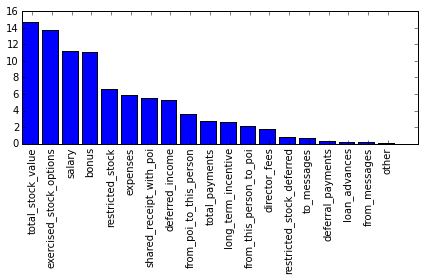

P_values of the features:
[0.00019888961161583125,
 0.00031708539094177883,
 0.0010804988836343044,
 0.001116797894661913,
 0.011503924040994174,
 0.016496127696725021,
 0.020631749260740857,
 0.022914796987957634,
 0.06039586400320103,
 0.098657582872612906,
 0.10860763583803998,
 0.14563361137749942,
 0.18255676196734019,
 0.38391106595301061,
 0.4094982620708012,
 0.6114395057794153,
 0.65779375785205985,
 0.67958884470452263,
 0.90545685671610254]


Naive bayes:
Accuracy: 0.62287, Precision: 0.20674, Recall: 0.64450, F1: 0.31305, F2: 0.45276
Total predictions: 15000, True positives: 1289, False positives: 4946, False negatives:  711, True negatives: 8054

SVM:
Accuracy: 0.75947, Precision: 0.27428, Recall: 0.48850, F1: 0.35131, F2: 0.42250
Total predictions: 15000, True positives:  977, False positives: 2585, False negatives: 1023, True negatives: 10415



/Users/tvikkula/anaconda/lib/python2.7/site-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [4]:
# Create a list of feature names, handy for plot labeling etc.
features_only_list = list(features_list)
features_only_list.remove('poi')

labels, features = targetFeatureSplit(data)

features_train, features_test, labels_train, labels_test = \
    stratifiedShuffleSplit(features, labels)

# Get feature importance:
importance, selector = getFeatureImportance(features_train, labels_train, features_only_list, k = 8)
plt.figure()
plotFeatureImportance(importance, features_only_list, plt)
plt.show()

### First try with all features: 
print 'P_values of the features:'
pprint.pprint([i[2] for i in importance])
print '\n'
# Do some hyperparam validation:
best_svc, svc_grid_scores = ClassifySVM.gridsearch(features_train, labels_train)

# Do fits based on hyperparam validation
nbfit = ClassifyNB.train(features_train, labels_train)
svmfit = ClassifySVM.train(features_train, labels_train, best_svc)

### Probably better to test with precision and recall:
print 'Naive bayes:'
test_classifier(nbfit, data)
print 'SVM:'
test_classifier(svmfit, data)


Already looking at the p-values, there seem to be quite a few variables that are likely to not be good features for the model. It seems that with a confidence interval of 95%, the 8 best features should be used.

Lets try with selector:

In [5]:
### Next try with selector
selector_train = selector.transform(features_train)

# Do some hyperparam validation:
best_svc, svc_grid_scores = ClassifySVM.gridsearch(selector_train, labels_train)

# Do fits based on hyperparam validation
nbfit = ClassifyNB.train(selector_train, labels_train)
svmfit = ClassifySVM.train(selector_train, labels_train, best_svc)

### Probably better to test with precision and recall:
print 'Naive bayes:'
test_classifier(nbfit, data)
print 'SVM:'
test_classifier(svmfit, data)

Naive bayes:
Accuracy: 0.62287, Precision: 0.20674, Recall: 0.64450, F1: 0.31305, F2: 0.45276
Total predictions: 15000, True positives: 1289, False positives: 4946, False negatives:  711, True negatives: 8054

SVM:
Accuracy: 0.70687, Precision: 0.28564, Recall: 0.79850, F1: 0.42076, F2: 0.58752
Total predictions: 15000, True positives: 1597, False positives: 3994, False negatives:  403, True negatives: 9006



Quite a bit better, especially with SVM.

PCA was used the following way:

In [6]:
labels, features = targetFeatureSplit(data)

features_train, features_test, labels_train, labels_test = \
    stratifiedShuffleSplit(features, labels)

### Do some PCA
pca = PCA.doPCA(features_train, n = 3)
transformed_train = pca.transform(features_train)
transformed_test = pca.transform(features_test)

features_only_list = ['pca'+str(i) for i in range(len(transformed_train[0]))]

# Do some hyperparam validation:
best_svc, svc_grid_scores = ClassifySVM.gridsearch(transformed_train, labels_train)

# Do fits based on hyperparam validation
nbfit = ClassifyNB.train(transformed_train, labels_train)
svmfit = ClassifySVM.train(transformed_train, labels_train, best_svc)

### Probably better to test with precision and recall:
print 'Naive bayes:'
test_classifier(nbfit, data)
print 'SVM:'
test_classifier(svmfit, data)

[ 0.35349896  0.14022969  0.11941153]
Naive bayes:
Accuracy: 0.62287, Precision: 0.20674, Recall: 0.64450, F1: 0.31305, F2: 0.45276
Total predictions: 15000, True positives: 1289, False positives: 4946, False negatives:  711, True negatives: 8054

SVM:
Accuracy: 0.70687, Precision: 0.28564, Recall: 0.79850, F1: 0.42076, F2: 0.58752
Total predictions: 15000, True positives: 1597, False positives: 3994, False negatives:  403, True negatives: 9006



PCA yeilded results that are exactly the same as SelectKFeatures.

Lets try combining both:

In [7]:
from sklearn.decomposition import RandomizedPCA
from sklearn.feature_selection import SelectKBest, f_classif

pca = RandomizedPCA(n_components=1)
selector = SelectKBest(score_func=f_classif, k=1)

# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca), ("f_classif", selector)])

# Use combined features to transform dataset:
combined_train = combined_features.fit(features_train, labels_train).transform(features_train)

# Do some hyperparam validation:
best_svc, svc_grid_scores = ClassifySVM.gridsearch(combined_train, labels_train)

# Do fits based on hyperparam validation
nbfit = ClassifyNB.train(combined_train, labels_train)
svmfit = ClassifySVM.train(combined_train, labels_train, best_svc)

### Probably better to test with precision and recall:
print 'Naive bayes:'
test_classifier(nbfit, data)
print 'SVM:'
test_classifier(svmfit, data)

Naive bayes:
Accuracy: 0.62287, Precision: 0.20674, Recall: 0.64450, F1: 0.31305, F2: 0.45276
Total predictions: 15000, True positives: 1289, False positives: 4946, False negatives:  711, True negatives: 8054

SVM:
Accuracy: 0.70687, Precision: 0.28564, Recall: 0.79850, F1: 0.42076, F2: 0.58752
Total predictions: 15000, True positives: 1597, False positives: 3994, False negatives:  403, True negatives: 9006



Unsurprisingly, same results.

Now, the Precision of the model should be bumped to over 0.3 in order to pass the evaluation requirements. To do that, lets organize a new feature.

Lets try to get a bit more bang for our buck from the email features. Lets see how a ratio-feature affects the model by organizing the following feature:
$$X_{email\_from\_poi\_ratio} = \frac{X_{from\_poi\_to\_this\_person}}{X_{from\_messages}}$$

In [3]:
# Courtesy of http://stackoverflow.com/questions/26248654/numpy-return-0-with-divide-by-zero
#, sets "divide-by-zero"-cases to 0
with np.errstate(divide='ignore', invalid='ignore'):
    c = np.divide(np.add(data[:,15], data[:,19]), np.add(data[:,13], data[:,2]))
    c[c == np.inf] = 0
    c = np.nan_to_num(c)
c = c.reshape(143,1)
fresh_data = np.append(data, c, 1)
fresh_data.shape

(143, 21)

Lets learn with the new feature(s):

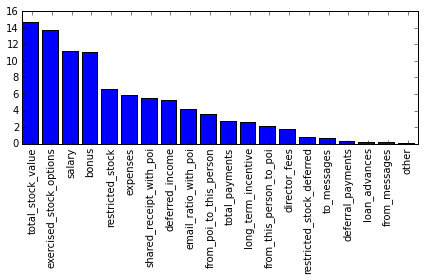

Best SVMC estimator found by grid search:
SVC(C=0.1, cache_size=200, class_weight='auto', coef0=0.0, degree=3, gamma=1,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Naive bayes:
Accuracy: 0.62287, Precision: 0.20674, Recall: 0.64450, F1: 0.31305, F2: 0.45276
Total predictions: 15000, True positives: 1289, False positives: 4946, False negatives:  711, True negatives: 8054

SVM:
Accuracy: 0.23267, Precision: 0.14767, Recall: 0.99650, F1: 0.25723, F2: 0.46357
Total predictions: 15000, True positives: 1993, False positives: 11503, False negatives:    7, True negatives: 1497



In [7]:
labels, features = targetFeatureSplit(fresh_data)

features_only_list = list(features_list)
features_only_list.remove('poi')
features_only_list.append('email_ratio_with_poi')

features_train, features_test, labels_train, labels_test = \
    stratifiedShuffleSplit(features, labels)

# Get feature importance:
importance, selector = getFeatureImportance(features_train, labels_train, features_only_list, k = 9)
plt.figure()
plotFeatureImportance(importance, features_only_list, plt)
plt.show()

### Next try with selector
selector_train = selector.transform(features_train)

# Do some hyperparam validation:
best_svc, svc_grid_scores = ClassifySVM.gridsearch(selector_train, labels_train)
print("Best SVMC estimator found by grid search:")
pprint.pprint(best_svc)


# Do fits based on hyperparam validation
nbfit = ClassifyNB.train(selector_train, labels_train)
svmfit = ClassifySVM.train(selector_train, labels_train, best_svc)


### Probably better to test with precision and recall:
print 'Naive bayes:'
test_classifier(nbfit, data)
print 'SVM:'
test_classifier(svmfit, data)

The feature itself seems quite ok, at least according to selectKBest. Testing the model, however, indicates that the precision of the model is incredibly low with this feature.

Lets try a different model to improve the precision:

In [11]:
labels, features = targetFeatureSplit(data)

features_train, features_test, labels_train, labels_test = \
    stratifiedShuffleSplit(features, labels)

### Do some PCA
pca = PCA.doPCA(features_train, n = 3)
transformed_train = pca.transform(features_train)
transformed_test = pca.transform(features_test)

# Do some hyperparam validation:
best_rfc, rfc_grid_scores = RFClassifier.gridsearch(transformed_train, labels_train, n = 100)

# Do fits based on hyperparam validation
rffit = RFClassifier.train(transformed_train, labels_train, best_rfc)

print 'Random Forest with 100 trees:'
test_classifier(rffit, data)

[ 0.35349896  0.14022969  0.11941153]
Random Forest with 100 trees:
Accuracy: 0.84480, Precision: 0.31448, Recall: 0.13900, F1: 0.19279, F2: 0.15646
Total predictions: 15000, True positives:  278, False positives:  606, False negatives: 1722, True negatives: 12394



Really poor performance on random forests. Using a high n is a bit of an overkil as the decision boundary and the dataset is not that complex.